In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('C:/Users/michelj8/Documents/Github/data_sets/house_supply.xlsx', sheet_name = 'data')
# data = pd.read_excel('C:/Users/michelj8/Documents/Github/data_sets/AISRSA.xlsx', sheet_name = 'data')
data.head()

,observation_date,MSACSR
0,1963-01-01,4.7
1,1963-02-01,6.6
2,1963-03-01,6.4
3,1963-04-01,5.3
4,1963-05-01,5.1


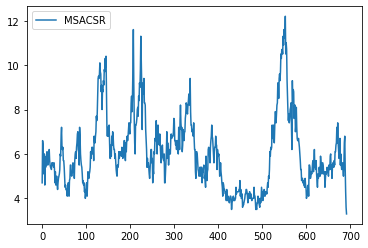

In [3]:
ts = data['MSACSR']
# ts = data['AISRSA']
pd.DataFrame(ts).plot()

# Fit Models

In [4]:
arma_model = ARIMA(ts, order=(1, 0, 0)).fit()
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 MSACSR   No. Observations:                  692
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -536.220
Date:                Tue, 13 Oct 2020   AIC                           1078.440
Time:                        15:37:09   BIC                           1092.059
Sample:                             0   HQIC                          1083.708
                                - 692                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9528      0.452     13.163      0.000       5.066       6.839
ar.L1          0.9481      0.011     89.929      0.000       0.927       0.969
sigma2         0.2749      0.010     27.558      0.0

In [5]:
ses_model = SimpleExpSmoothing(ts).fit()
print( ses_model.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  endog   No. Observations:                  692
Model:             SimpleExpSmoothing   SSE                            189.536
Optimized:                       True   AIC                           -892.145
Trend:                           None   BIC                           -883.066
Seasonal:                        None   AICC                          -892.087
Seasonal Periods:                None   Date:                 Tue, 13 Oct 2020
Box-Cox:                        False   Time:                         15:37:10
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8165826                alpha                 True
initial_level              5.0348917                

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


646.0680474401163
868.7890811034852


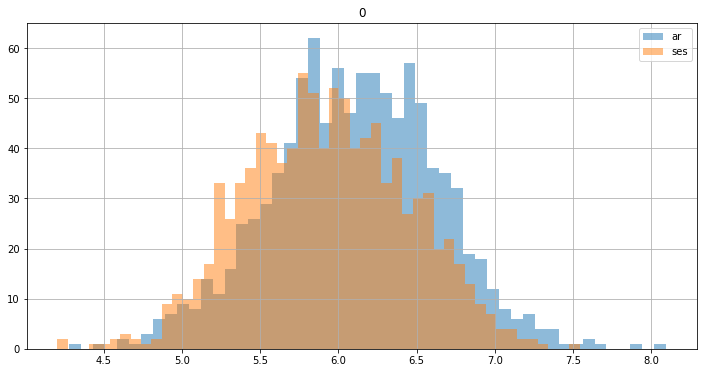

In [6]:
fig, ax = plt.subplots(figsize = (12,6))
bin_count = 50

# index_forecast = len(ts)
index_forecast = 255

ar_mean = list(arma_model.predict(index_forecast))[0]
ar_std = np.sqrt(arma_model.params[2])
ar_forecast = np.random.normal(ar_mean,ar_std,1000)

ses_mean = list(ses_model.predict(index_forecast))[0]
ses_std =  np.sqrt(ses_model.sse/len(ts))
ses_forecast = np.random.normal(ses_mean, ses_std, 1000)

actual = ts[index_forecast+1]
combined_forecast = .5*(ses_forecast + ar_forecast)

pd.DataFrame(ar_forecast).hist(bins = bin_count, alpha = .5, label = 'ar', ax = ax)
pd.DataFrame(ses_forecast).hist(bins = bin_count, alpha = .5,label = 'ses', ax = ax)
# pd.DataFrame(combined_forecast).hist(bins = bin_count, alpha = .5,label = 'combo', ax = ax)
plt.legend(loc='upper right')


print( np.sum(np.square(ar_forecast-actual)))
print( np.sum(np.square(ses_forecast-actual)))
# print( np.sum(np.square(combined_forecast-actual)))

,ar_pct,ses_pct,conv_combo_pct,quantile_combo_pct,theory
alpha,,,,,
0.010000,0.013006,0.008671,0.004335,0.004335,0.010000
0.118889,0.125723,0.104046,0.125723,0.115607,0.118889
0.227778,0.226879,0.210983,0.235549,0.219653,0.227778
0.336667,0.322254,0.317919,0.348266,0.320809,0.336667
0.445556,0.417630,0.430636,0.462428,0.419075,0.445556
0.554444,0.511561,0.521676,0.570809,0.533237,0.554444
0.663333,0.612717,0.624277,0.679191,0.622832,0.663333
0.772222,0.712428,0.739884,0.787572,0.738439,0.772222
0.881111,0.825145,0.823699,0.861272,0.822254,0.881111


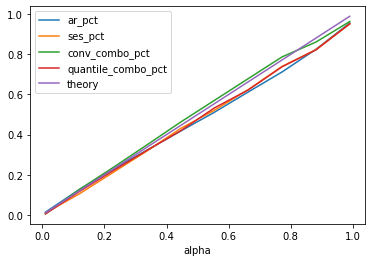

In [14]:
coverage_df = pd.DataFrame(columns = ['alpha','ar_pct', 'ses_pct', 'conv_combo_pct','quantile_combo_pct', 'theory']).set_index('alpha')
alpha_list = np.linspace(.01,.99,10)

weight = .25
conv_var_adjust = 2

for alpha in alpha_list:
    coverage_df.loc[alpha] = 0.0

for time in range(1,len(ts)-1):
# for time in range(1, 10):
    actual = ts[time+1]
    ar_mean = list(arma_model.predict(time))[0]
    ar_std = np.sqrt(arma_model.params[2])

    ses_mean = list(ses_model.predict(time))[0]
    ses_std =  np.sqrt(ses_model.sse/len(ts))

    combo_mean = weight*ar_mean + (1-weight)*ses_mean
    combo_std = np.sqrt(2*( np.square(weight)*np.square(ar_std)+np.square(1-weight)*np.square(ses_std) ) )
    
    quant_combo_std = weight*ar_std + (1-weight)*ses_std
    quant_combo_mean = weight*ar_mean + (1-weight)*ses_mean
    
    for alpha in alpha_list:
        ar_ci = scipy.stats.norm.interval(alpha, loc=ar_mean, scale=ar_std)
        ses_ci = scipy.stats.norm.interval(alpha, loc=ses_mean, scale=ses_std)
        conv_combo_ci = scipy.stats.norm.interval(alpha, loc=combo_mean, scale=combo_std)
        quantile_combo_ci = scipy.stats.norm.interval(alpha, loc=quant_combo_mean, scale= quant_combo_std)
        
        
        coverage_df.loc[alpha] = coverage_df.loc[alpha] + [1*(actual > ar_ci[0])*(actual<ar_ci[1]),
                                                           1*(actual > ses_ci[0])*(actual<ses_ci[1]),
                                                           1*(actual > conv_combo_ci[0])*(actual<conv_combo_ci[1]),
                                                           1*(actual > quantile_combo_ci[0])*(actual<quantile_combo_ci[1]),
                                                           1]
        
        
coverage_df = coverage_df.div(len(ts))
coverage_df['theory'] = alpha_list
coverage_df.plot()
coverage_df

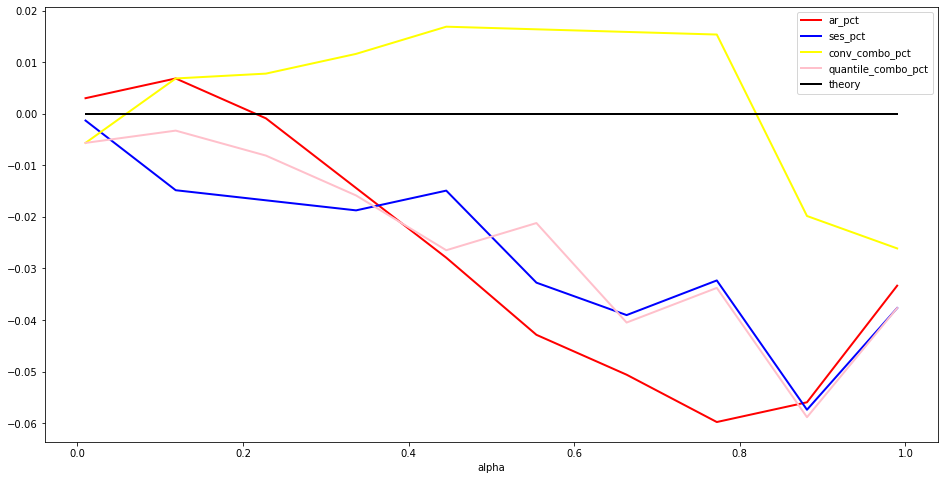

In [15]:
fig, ax = plt.subplots(figsize = (16,8))

# coverage_df.drop('conv_combo_pct', axis = 1).plot(ax = ax)
coverage_df.subtract(coverage_df['theory'], axis =0).plot( ax= ax, linewidth =2,
                                                          color = ['red','blue','yellow','pink','black'])


In [16]:
print( np.sum(np.square(coverage_df['ar_pct']-coverage_df['theory'])) )
print( np.sum(np.square(coverage_df['ses_pct']-coverage_df['theory'])) )
print( np.sum(np.square(coverage_df['conv_combo_pct']-coverage_df['theory'])) )
print( np.sum(np.square(coverage_df['quantile_combo_pct']-coverage_df['theory'])) )

0.013265180061949055
0.009439542720240364
0.002389515062190401
0.009177403806292169


In [20]:
np.dot( (coverage_df['ses_pct']-coverage_df['theory']).values  ,np.exp(-(np.square(coverage_df.index.values - .5))) )

-0.24262740813188177

In [21]:
np.dot( (coverage_df['ar_pct']-coverage_df['theory']).values  ,np.exp(-(np.square(coverage_df.index.values - .5))) )

-0.25663515328466224

In [22]:
np.dot( (coverage_df['quantile_combo_pct']-coverage_df['theory']).values  ,np.exp(-(np.square(coverage_df.index.values - .5))) )

-0.22917283130739768

In [23]:
np.dot( (coverage_df['conv_combo_pct']-coverage_df['theory']).values  ,np.exp(-(np.square(coverage_df.index.values - .5))) )

0.04508896727626981